# Module import

In [152]:
from netCDF4 import Dataset                             
import numpy as np                                      
import matplotlib.pyplot as plt           
import matplotlib.colors as mcolors              
import cartopy.crs as ccrs                              
import cartopy.feature as cfeature     
import cartopy.io.shapereader as shpreader
import sys
import torch 
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime, timedelta
import os

In [153]:
sys.path.append("/home/users/mendrika/Zambia-Intercomparison/models/training")
from zambia_ensemble_hybrid import Core2MapModel

# Choose nowcast origin and lead time (in hour)

In [ ]:
year = "2024"
month = "01"
day = "10"
hour = "12"
minute = "00"

In [155]:
lead_time = 6

# Configurations

## Zambia extent

In [156]:
DISPLAY_LON_MIN = 21.167515
DISPLAY_LON_MAX = 35.316326
DISPLAY_LAT_MIN = -18.414806
DISPLAY_LAT_MAX = -7.9918404

# NetNCC Base Directory

In [157]:
NetCC_geodata = Dataset("/gws/ssde/j25b/swift/NetNCC_preds/coords_zambia_MSG.nc")
NetCC_lats = NetCC_geodata["lat"][:]
NetCC_lons = NetCC_geodata["lon"][:]

NetCC_CONTEXT_LAT_MIN = np.min(NetCC_lats)
NetCC_CONTEXT_LAT_MAX = np.max(NetCC_lats)
NetCC_CONTEXT_LON_MIN = np.min(NetCC_lons)
NetCC_CONTEXT_LON_MAX = np.max(NetCC_lons)

In [158]:
def load_NetCC_nowcast(year, month, day, hour, minute, lead_time):
    path_NetNCC = f'/gws/ssde/j25b/swift/NetNCC_preds/{year}/{month}'
    file = f"{path_NetNCC}/{year}{month}{day}{hour}{minute}_leadtime_{lead_time}hr.nc"
    return Dataset(file, mode='r')["core_prob"][:]

# NFLICS

In [159]:
geodata_flics = np.load("/gws/nopw/j04/wiser_ewsa/mrakotomanga/Intercomparison/metadata/nflics_latlon_meshgrid.npz")
NFLICS_lats = geodata_flics["lats"]
NFLICS_lons = geodata_flics["lons"]

In [160]:
def load_NFLICS_nowcast(year, month, day, hour, minute, lead_time):
    NFLICS_BaseDir = f"/gws/ssde/j25b/swift/nflics_nowcasts/{year}/{month}/{day}/{hour}{minute}"
    file = f"{NFLICS_BaseDir}/Nowcast_{year}{month}{day}{hour}{minute}_000_sadc.nc"
    data = Dataset(file, mode='r')["Probability"][lead_time, :, :]
    return data

# Ground truth 

In [161]:
def update_hour(date_dict, hours_to_add, minutes_to_add):
    """
    Add hours and minutes to a datetime dictionary and return the updated dict and a generated file path.

    Args:
        date_dict     (dict): Keys: 'year', 'month', 'day', 'hour', 'minute' as strings, e.g. "01", "23"
        hours_to_add   (int): Number of hours to add.
        minutes_to_add (int): Number of minutes to add.

    Returns:
        tuple:
            - dict: Updated datetime dictionary with all fields as zero-padded strings.
            - str: File path in the format YYYY/MM/YYYYMMDDHHMM.nc
    """
    # Parse the original time
    time_obj = datetime(
        int(date_dict["year"]),
        int(date_dict["month"]),
        int(date_dict["day"]),
        int(date_dict["hour"]),
        int(date_dict["minute"])
    )

    # Add hours
    updated = time_obj + timedelta(hours=hours_to_add, minutes=minutes_to_add)

    # Format updated dictionary
    new_date_dict = {
        "year":   f"{updated.year:04d}",
        "month":  f"{updated.month:02d}",
        "day":    f"{updated.day:02d}",
        "hour":   f"{updated.hour:02d}",
        "minute": f"{updated.minute:02d}"
    }

    # Generate file path
    file_path = f"{new_date_dict['year']}/{new_date_dict['month']}/{new_date_dict['year']}{new_date_dict['month']}{new_date_dict['day']}{new_date_dict['hour']}{new_date_dict['minute']}.nc"

    return {'time': new_date_dict, 'path': file_path}

In [162]:
def load_wavelet_dataset(year, month, day, hour, minute, lead_time):
    
    nowcast_origin = {
        "year":   year,
        "month":  month,
        "day":    day,
        "hour":   hour,
        "minute": minute,
    }

    nowcast_lt = update_hour(nowcast_origin, hours_to_add=lead_time, minutes_to_add=0)["time"]

    path_core = f"/gws/nopw/j04/cocoon/SSA_domain/ch9_wavelet/{nowcast_lt['year']}/{nowcast_lt['month']}"
    file = f"{path_core}/{nowcast_lt['year']}{nowcast_lt['month']}{nowcast_lt['day']}{nowcast_lt['hour']}{nowcast_lt['minute']}.nc"
    return Dataset(file, mode='r')["cores"]

# ZCAST

In [163]:
y_min, y_max = 580, 930
x_min, x_max = 1480, 1850

In [164]:
geodata = np.load("/gws/nopw/j04/cocoon/SSA_domain/lat_lon_2268_2080.npz")
Zambia_lons = geodata["lon"][y_min:y_max, x_min:x_max]
Zambia_lats = geodata["lat"][y_min:y_max, x_min:x_max]

In [165]:
def load_zcast_input(year, month, day, hour, minute, lead_time):
    input_path_zcast = f"/gws/nopw/j04/wiser_ewsa/mrakotomanga/Intercomparison/raw/inputs_t0"
    core_input = f"{input_path_zcast}/input-{year}{month}{day}_{hour}{minute}.pt"
    return torch.load(core_input)
    

In [166]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [167]:
ENSEMBLE_DIR = f"/gws/nopw/j04/wiser_ewsa/mrakotomanga/Intercomparison/checkpoints/ensemble_hybrid/t{lead_time}"

In [168]:
N_MC = 10  # number of MC dropout samples per model

def enable_dropout(model, p=0.05):
    """
    Enable dropout layers for Monte Carlo sampling, with a custom rate p.
    This keeps the model in eval mode otherwise (BatchNorm, etc.).
    """
    for m in model.modules():
        if isinstance(m, (torch.nn.Dropout, torch.nn.Dropout2d)):
            m.train()  # keep dropout active
            m.p = p    # lower dropout probability (default 0.05)


def load_models(ensemble_dir):
    models = []
    for seed in sorted(os.listdir(ensemble_dir)):
        ckpt = os.path.join(ensemble_dir, seed, "best-core2map.ckpt")
        if os.path.exists(ckpt):
            model = Core2MapModel.load_from_checkpoint(ckpt, map_location=DEVICE)
            model.eval().to(DEVICE)
            models.append(model)
            print(f"Loaded {ckpt}")
    return models

def mc_predict(model, x, g, n_samples=10):
    enable_dropout(model)
    preds = []
    with torch.no_grad():
        for _ in range(n_samples):
            preds.append(torch.sigmoid(model(x, g)))
    preds = torch.stack(preds)
    return preds.mean(0), preds.var(0)

def ensemble_mc_predict(models, x, g, n_mc=10):
    mean_list, var_list = [], []
    for m in models:
        mean_i, var_i = mc_predict(m, x, g, n_mc)
        mean_list.append(mean_i)
        var_list.append(var_i)
    mean_stack = torch.stack(mean_list)
    var_stack = torch.stack(var_list)
    mean_ens = mean_stack.mean(0)
    var_ens = var_stack.mean(0) + mean_stack.var(0)  # total variance
    return mean_ens, var_ens

In [169]:
models = load_models(ENSEMBLE_DIR)
print(f"Loaded {len(models)} ensemble members.")

Loaded /gws/nopw/j04/wiser_ewsa/mrakotomanga/Intercomparison/checkpoints/ensemble_hybrid/t6/seed1337/best-core2map.ckpt
Loaded /gws/nopw/j04/wiser_ewsa/mrakotomanga/Intercomparison/checkpoints/ensemble_hybrid/t6/seed2025/best-core2map.ckpt
Loaded /gws/nopw/j04/wiser_ewsa/mrakotomanga/Intercomparison/checkpoints/ensemble_hybrid/t6/seed42/best-core2map.ckpt
Loaded /gws/nopw/j04/wiser_ewsa/mrakotomanga/Intercomparison/checkpoints/ensemble_hybrid/t6/seed777/best-core2map.ckpt
Loaded /gws/nopw/j04/wiser_ewsa/mrakotomanga/Intercomparison/checkpoints/ensemble_hybrid/t6/seed999/best-core2map.ckpt
Loaded 5 ensemble members.


In [170]:
SCALER_PATH = "/gws/nopw/j04/wiser_ewsa/mrakotomanga/Intercomparison/scaling/scaler_realcores.pt"
COLS_TO_SCALE = [0, 1, 2, 3, 4, 5, 6, 7]
MASK_COL_INDEX = 8
LAG_COL_INDEX = 9

# ---------------------------------------------------------------------
# Load the scaler
# ---------------------------------------------------------------------
scaler = torch.load(SCALER_PATH, weights_only=False)
mean = np.asarray(scaler["mean"])   # shape (8,)
scale = np.asarray(scaler["scale"]) # shape (8,)

# ---------------------------------------------------------------------
# Load the preprocessed input (ZCAST-style)
# ---------------------------------------------------------------------
zcast_input = load_zcast_input(year, month, day, hour, minute, lead_time)

input_tensor = zcast_input["input_tensor"].clone().unsqueeze(0)     # (1, 288, 10)
global_context = zcast_input["global_context"].clone().unsqueeze(0) # (1, 4)

# ---------------------------------------------------------------------
# Scale and normalise the input
# ---------------------------------------------------------------------
if input_tensor.shape == (1, 288, 10):
    # Convert mean/scale to tensors on the same device
    mean_t = torch.tensor(mean, dtype=input_tensor.dtype, device=input_tensor.device)
    scale_t = torch.tensor(scale, dtype=input_tensor.dtype, device=input_tensor.device)

    # Mask: only real storm cores (mask == 1)
    mask = input_tensor[:, :, MASK_COL_INDEX] > 0.5

    # Scale each feature independently
    for col in COLS_TO_SCALE:
        x = input_tensor[:, :, col]
        x_scaled = (x - mean_t[col]) / scale_t[col]
        input_tensor[:, :, col] = torch.where(mask, x_scaled, x)

    # Normalise lag to [-1, 1]
    input_tensor[:, :, LAG_COL_INDEX] = 2 * (input_tensor[:, :, LAG_COL_INDEX] / 120.0) - 1.0

else:
    print("Warning: unexpected input shape, skipping scaling.")
    input_tensor = torch.zeros((1, 288, 10))
    global_context = torch.zeros((1, 4))

In [171]:
mean_pred, var_pred = ensemble_mc_predict(models, input_tensor.to(DEVICE), global_context.to(DEVICE))

In [172]:
m = mean_pred.squeeze().cpu().numpy()
s = var_pred.squeeze().cpu().numpy()**0.5

# Load all nowcasts and ground truth

In [173]:
netncc = load_NetCC_nowcast(year, month, day, hour, minute, lead_time)

In [174]:
nflics = load_NFLICS_nowcast(year, month, day, hour, minute, lead_time)

In [175]:
ground_truth = load_wavelet_dataset(year, month, day, hour, minute, lead_time)[0, y_min:y_max, x_min:x_max] != 0

In [176]:
CONTEXT_LAT_MIN = np.min(Zambia_lats)
CONTEXT_LAT_MAX = np.max(Zambia_lats)
CONTEXT_LON_MIN = np.min(Zambia_lons)
CONTEXT_LON_MAX = np.max(Zambia_lons)

# All products

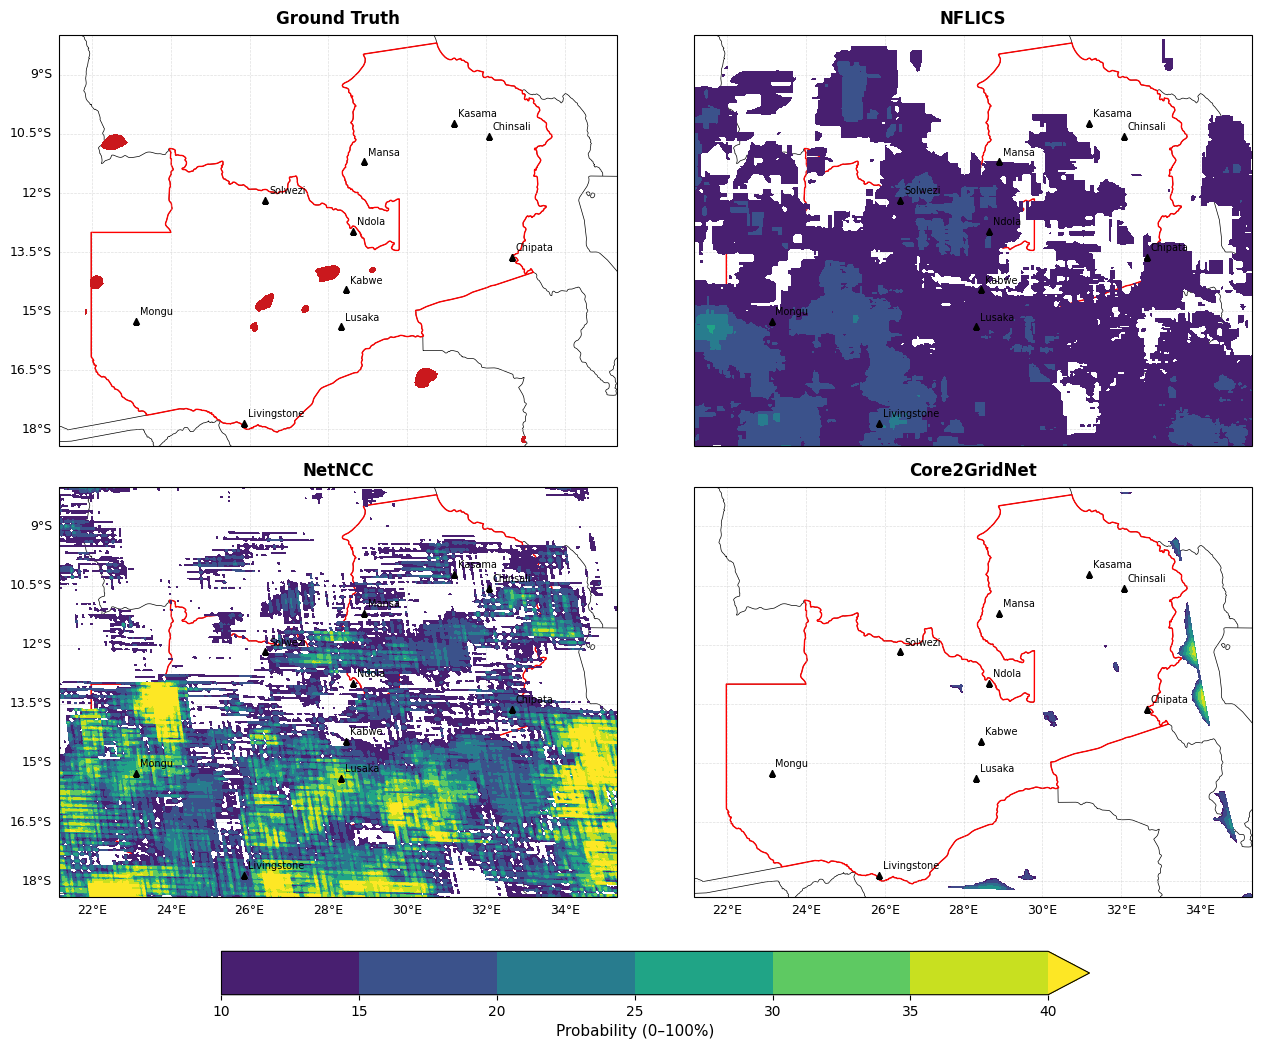

In [177]:
# --- Four-panel comparison: Ground Truth, NFLICS, NetNCC, Core2GridNet ---

locations = {
    "Lusaka": [-15.3875, 28.3228],
    "Ndola": [-12.9683, 28.6366],
    "Kasama": [-10.2129, 31.1808],
    "Chinsali": [-10.5500, 32.0667],
    "Kabwe": [-14.4469, 28.4464],
    "Livingstone": [-17.8419, 25.8542],
    "Mongu": [-15.2484, 23.1274],
    "Mansa": [-11.1996, 28.8943],
    "Solwezi": [-12.1722, 26.3981],
    "Chipata": [-13.6339, 32.6508]
}


fig, axes = plt.subplots(
    2, 2, figsize=(16, 14),
    subplot_kw={'projection': ccrs.PlateCarree()}
)

plt.subplots_adjust(wspace=0.05, hspace=0.1)

# Common plotting setup
def setup_ax(ax, title, show_left=False, show_bottom=False):
    ax.set_extent([DISPLAY_LON_MIN, DISPLAY_LON_MAX, DISPLAY_LAT_MIN, DISPLAY_LAT_MAX],
                  crs=ccrs.PlateCarree())
    ax.set_title(title, fontsize=12, weight="bold", pad=8)
    ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='black', zorder=0)
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue', zorder=0)
    ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=0.5, zorder=1)
    ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=0.5, zorder=1)

    # Zambia outline
    shapename = 'admin_0_countries'
    countries_shp = shpreader.natural_earth(resolution='10m',
                                            category='cultural', name=shapename)
    for country in shpreader.Reader(countries_shp).records():
        if country.attributes['NAME'] == 'Zambia':
            ax.add_geometries(
                [country.geometry], crs=ccrs.PlateCarree(),
                facecolor='none', edgecolor='red', linewidth=1.0, zorder=2
            )

    # City markers
    for name, (lat, lon) in locations.items():
        ax.plot(lon, lat, marker="^", color="black", markersize=5,
                transform=ccrs.PlateCarree(), zorder=3)
        ax.text(lon + 0.1, lat + 0.1, name, fontsize=7,
                transform=ccrs.PlateCarree(), ha='left', va='bottom',
                color='black', zorder=4)

    # Gridlines with labels
    gl = ax.gridlines(draw_labels=True, alpha=0.4, linestyle='--', linewidth=0.5)
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = show_left
    gl.bottom_labels = show_bottom
    gl.xlabel_style = {'size': 9}
    gl.ylabel_style = {'size': 9}
    return ax


# --- Row 1: Ground Truth (left) and NFLICS (right) ---
ax_gt = setup_ax(axes[0, 0], "Ground Truth", show_left=True, show_bottom=False)
gt_masked = np.ma.masked_where(ground_truth <= 0, ground_truth)
im1 = ax_gt.contourf(Zambia_lons, Zambia_lats, gt_masked,
                     transform=ccrs.PlateCarree(),
                     cmap="Reds", vmin=0, vmax=1, zorder=2)

ax_nf = setup_ax(axes[0, 1], "NFLICS", show_left=False, show_bottom=False)
NFLICS_masked = np.ma.masked_where(nflics <= 10, nflics)
im2 = ax_nf.contourf(NFLICS_lons, NFLICS_lats, NFLICS_masked,
                     transform=ccrs.PlateCarree(),
                     cmap="viridis", extend="max", zorder=2)

# --- Row 2: NetNCC (left) and Core2GridNet (right) ---
ax_nc = setup_ax(axes[1, 0], "NetNCC", show_left=True, show_bottom=True)
NetCC_masked = np.ma.masked_where(netncc <= 5, netncc)
im3 = ax_nc.contourf(NetCC_lons, NetCC_lats, NetCC_masked,
                     transform=ccrs.PlateCarree(),
                     cmap="viridis", extend="max", zorder=2)

ax_cg = setup_ax(axes[1, 1], "Core2GridNet", show_left=False, show_bottom=True)
C2G_masked = np.ma.masked_where(mean_pred <= 0.3, mean_pred)
im4 = ax_cg.contourf(Zambia_lons, Zambia_lats, C2G_masked.squeeze(0).squeeze(0),
                     transform=ccrs.PlateCarree(),
                     cmap="viridis", extend="max", zorder=2)

# --- Shared colourbar across all panels ---
cbar = fig.colorbar(im2, ax=axes.ravel().tolist(),
                    orientation="horizontal", shrink=0.7, pad=0.05)
cbar.set_label("Probability (0–100%)", fontsize=11)

plt.show()


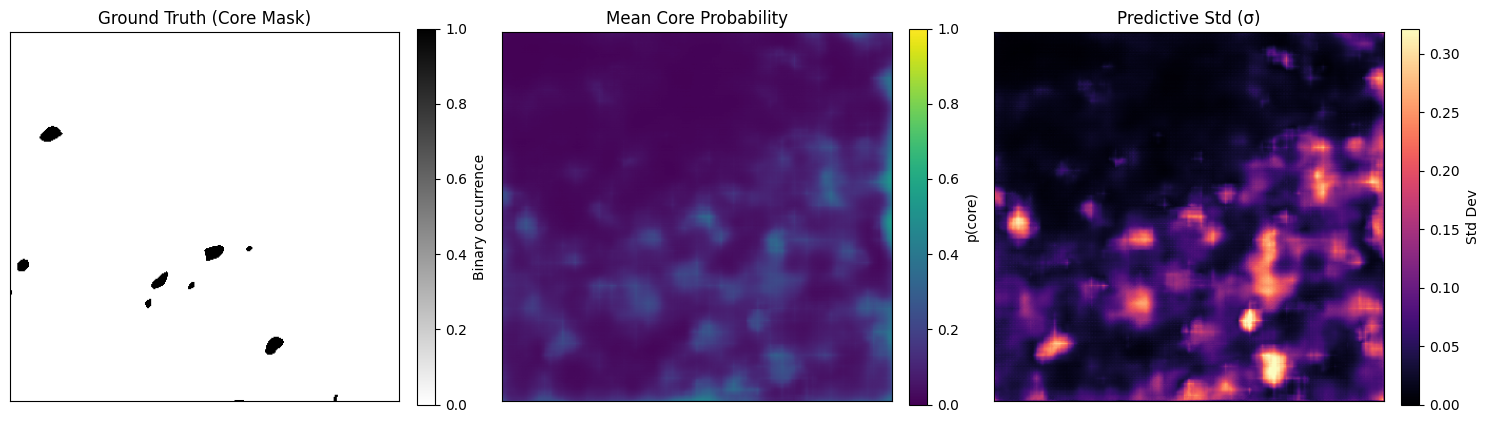

In [178]:
# Prepare arrays
mean_map = mean_pred.squeeze().cpu().numpy()
std_map  = np.sqrt(var_pred.squeeze().cpu().numpy())

# Create figure with 3 panels
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

im0 = axes[0].imshow(ground_truth, cmap="gray_r", vmin=0, vmax=1, origin="lower")
axes[0].set_title("Ground Truth (Core Mask)")
cb0 = plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04, shrink=0.8)
cb0.set_label("Binary occurrence")

im1 = axes[1].imshow(mean_map, cmap="viridis", vmin=0, vmax=1, origin="lower")
axes[1].set_title("Mean Core Probability")
cb1 = plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04, shrink=0.8)
cb1.set_label("p(core)")

im2 = axes[2].imshow(std_map, cmap="magma", vmin=0, vmax=std_map.max()*0.9, origin="lower")
axes[2].set_title("Predictive Std (σ)")
cb2 = plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04, shrink=0.8)
cb2.set_label("Std Dev")

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()


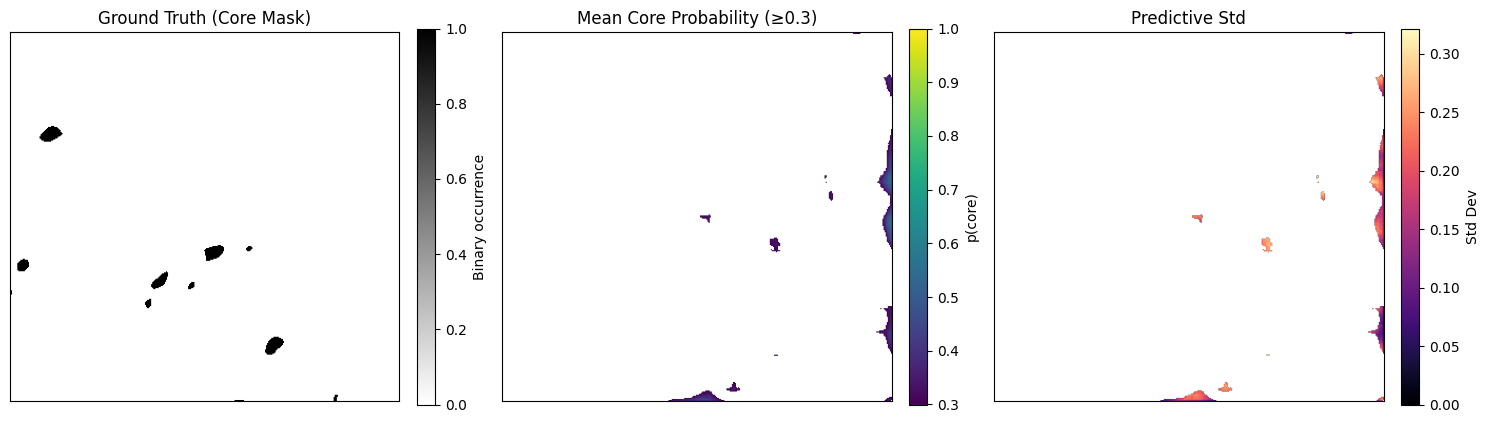

In [179]:
# Prepare arrays
mean_map = mean_pred.squeeze().cpu().numpy()
std_map  = np.sqrt(var_pred.squeeze().cpu().numpy())

# Thresholds
THRESH_P = 0.3   # probability threshold
THRESH_S = 0  # std threshold (keep σ > 0.05)

# Combined mask
mask = (mean_map < THRESH_P) | (std_map < THRESH_S) | np.isnan(mean_map)

# Apply mask
mean_masked = np.ma.masked_where(mask, mean_map)
std_masked  = np.ma.masked_where(mask, std_map)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

im0 = axes[0].imshow(ground_truth, cmap="gray_r", vmin=0, vmax=1, origin="lower")
axes[0].set_title("Ground Truth (Core Mask)")
cb0 = plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04, shrink=0.8)
cb0.set_label("Binary occurrence")

im1 = axes[1].imshow(mean_masked, cmap="viridis", vmin=THRESH_P, vmax=1, origin="lower")
axes[1].set_title(f"Mean Core Probability (≥{THRESH_P})")
cb1 = plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04, shrink=0.8)
cb1.set_label("p(core)")

im2 = axes[2].imshow(std_masked, cmap="magma", vmin=THRESH_S, vmax=std_map.max()*0.9, origin="lower")
axes[2].set_title(f"Predictive Std")
cb2 = plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04, shrink=0.8)
cb2.set_label("Std Dev")

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()
